In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, initializers
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import tensorflow_datasets as tfds
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)
assert float(tf.__version__[:3]) >= 2.3

#tfds.list_builders()

In [2]:
import time

In [3]:
# 資料處理
test_data, info = tfds.load("cifar10", split="test", with_info=True)

In [4]:
# 定義圖像縮放
def parse_aug_fn(dataset):
    def zoom(x, sh = 224, sw = 224):
        x = tf.image.resize(x, (sh, sw))
        return x
    
    # 影像標準化
    x = tf.cast(dataset['image'], tf.float32) / 255.
    # 影像放大到224*224
    x = zoom(x)
    # y = tf.one_hot(dataset['label'], 10)
    y = dataset['label']
    
    return x, y

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
test_data = test_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

In [6]:
test_data_np = tfds.as_numpy(test_data)
test_images = []
test_labels = []
for data in test_data_np:
  test_images.append(data[0])
  test_labels.append(data[1])

In [7]:
# tflite檔案路徑
import pathlib
tflite_models_dir = pathlib.Path("cifar10/models")
tflite_model_file = tflite_models_dir/"cifar10_MobileNet.tflite"
tflite_model_quant_file = tflite_models_dir/"cifar10_MobileNet_quant.tflite"

In [8]:
# test_images = test_images[:50]
# test_labels = test_labels[:50]

In [13]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  Time_start = time.time()
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    Time_test = time.time()
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()

    output = interpreter.get_tensor(output_details["index"])[0]
    Time_test = time.time() - Time_test
    
    print(Time_test)

    predictions[i] = output.argmax()
    
    if (i+1)%500==0:
      
      Time_mid = time.time()
      t = Time_mid - Time_start
      h = int(t/3600)
      m = int(t/60)%60
      s = int(t%60)
      print("已評估{}%".format(round(100*(i+1)/len(test_image_indices),2)),end=",")
      print("已耗時{h} h {m} m {s} s".format(h=h,m=m,s=s))
  return predictions

In [14]:
# Change this to test a different image
test_image_index = 5

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global test_labels

  predictions = run_tflite_model(tflite_file, [test_image_index])

  plt.imshow(test_images[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)

0.07097697257995605


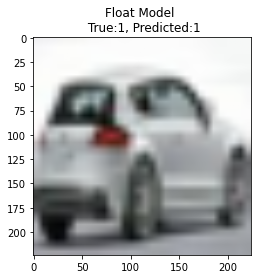

In [15]:
test_model(tflite_model_file, test_image_index, model_type="Float")

2.76470685005188


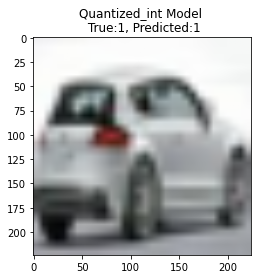

In [16]:
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized_int")

In [13]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global test_images
  global test_labels

  # test_image_indices = range(test_images.shape[0])
  test_image_indices = range(len(test_images))
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

In [14]:
tStart = time.time()
evaluate_model(tflite_model_file, model_type="Float")
tEnd = time.time()
t = tEnd-tStart
print("It cost {h} hour {m} min {s} sec".format(h=int(t/3600),m=int((t%3600)/60), s=int(t%60)))

已評估5.0%,已耗時0 h 0 m 24 s
已評估10.0%,已耗時0 h 0 m 49 s
已評估15.0%,已耗時0 h 1 m 14 s
已評估20.0%,已耗時0 h 1 m 39 s
已評估25.0%,已耗時0 h 2 m 4 s
已評估30.0%,已耗時0 h 2 m 29 s
已評估35.0%,已耗時0 h 2 m 53 s
已評估40.0%,已耗時0 h 3 m 18 s
已評估45.0%,已耗時0 h 3 m 43 s
已評估50.0%,已耗時0 h 4 m 8 s
已評估55.0%,已耗時0 h 4 m 33 s
已評估60.0%,已耗時0 h 4 m 57 s
已評估65.0%,已耗時0 h 5 m 22 s
已評估70.0%,已耗時0 h 5 m 47 s
已評估75.0%,已耗時0 h 6 m 12 s
已評估80.0%,已耗時0 h 6 m 37 s
已評估85.0%,已耗時0 h 7 m 2 s
已評估90.0%,已耗時0 h 7 m 26 s
已評估95.0%,已耗時0 h 7 m 51 s
已評估100.0%,已耗時0 h 8 m 16 s
Float model accuracy is 89.6100% (Number of test samples=10000)
It cost 0 hour 8 min 16 sec


In [15]:
tStart = time.time()
evaluate_model(tflite_model_quant_file, model_type="Quantized")
tEnd = time.time()
t = tEnd-tStart
print("It cost {h} hour {m} min {s} sec".format(h=int(t/3600),m=int((t%3600)/60), s=int(t%60)))

已評估5.0%,已耗時0 h 20 m 23 s
已評估10.0%,已耗時0 h 40 m 46 s
已評估15.0%,已耗時1 h 1 m 5 s
已評估20.0%,已耗時1 h 21 m 24 s
已評估25.0%,已耗時1 h 41 m 45 s
已評估30.0%,已耗時2 h 2 m 4 s
已評估35.0%,已耗時2 h 22 m 22 s
已評估40.0%,已耗時2 h 42 m 40 s
已評估45.0%,已耗時3 h 2 m 59 s
已評估50.0%,已耗時3 h 23 m 18 s
已評估55.0%,已耗時3 h 43 m 38 s
已評估60.0%,已耗時4 h 3 m 57 s
已評估65.0%,已耗時4 h 24 m 8 s
已評估70.0%,已耗時4 h 44 m 2 s
已評估75.0%,已耗時5 h 3 m 56 s
已評估80.0%,已耗時5 h 23 m 50 s
已評估85.0%,已耗時5 h 43 m 46 s
已評估90.0%,已耗時6 h 3 m 40 s
已評估95.0%,已耗時6 h 23 m 49 s
已評估100.0%,已耗時6 h 44 m 33 s
Quantized model accuracy is 88.9000% (Number of test samples=10000)
It cost 6 hour 44 min 33 sec
